## FastCampus PJT - Team 3
##### 심성식 김민수 심승현 이희상 이용기

### 라이브러리 관련 및 환경 셋업

###### 필요한 모듈 설치

In [1]:
# !pip install numpy
# !pip install pandas
# !pip install matplotlib
# !pip install scipy
# !pip install seaborn

###### 필요한 모듈 모두 불러오기

In [2]:
import os
import time
import numpy as np
import pandas as pd
from matplotlib import rc
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import re
import glob
import seaborn as sns
import datetime

###### 폰트 확인

In [3]:
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False
font_path = fm.findfont('AppleGothic')
if not font_path:
    print('Warning: AppleGothic font not found')
else:
    print("AppleGothic font found at ", font_path)

font_prop = fm.FontProperties(fname=font_path, size=12)


AppleGothic font found at  /System/Library/Fonts/Supplemental/AppleGothic.ttf


### 경로 설정

###### 폴더 생성 및 경로 variable 생성

In [4]:
# Creating folders and variables for data paths

dataset = "./dataset/"
GROUPED = dataset + "Grouped/"
FINAL_GROUP = dataset + "Grouped_Final/"

if not os.path.exists("./dataset"):
    os.mkdir("./dataset")

if not os.path.exists(dataset + "Grouped"):
    os.mkdir(dataset + "Grouped")

if not os.path.exists(dataset + "Grouped_Final"):
    os.mkdir(dataset + "Grouped_Final")

###### 파일 경로 불러올 딕셔너리 생성

In [5]:
# Adding up all file locations into a dictionary.

file_locations = {
    "dataset" : dataset,
    'grouped': GROUPED,
    'group_final' : FINAL_GROUP #,
    # to be added further
}

all_file_locations = {}
for key, value in file_locations.items():
    all_file_locations[key] = glob.glob(value + "*.csv")

'''

type all_file_locations["key"] to call
keys are "dataset", "grouped", "group_final", etc.; to be added further.

'''

'\n\ntype all_file_locations["key"] to call\nkeys are "dataset", "grouped", "group_final", etc.; to be added further.\n\n'

#### 준비

###### Definition 설정

In [6]:
# Local definitions - 1

def clean_course_name(course_name):
    '''
    course name 중 첫 구절이 ( 으로 시작하고, 
    ~ 로 스플릿한 구절 중 0번째 len이 7인 경우; 예시: "(220123"
    ) 이후의 course name을 return합니다.
    
    아래와 같이 사용해 주시면 편합니다.
    df["course_name"] = df["course_name"].apply(clean_course_name)

    '''
    if course_name.startswith("("):
        # Classify the date range to cleanse.
        if "~" in course_name:
            temp = course_name.split("~")[0]
            # if the value before ~ is in year format, remove the whole bracket.
            if len(temp) == 7:
                return course_name.split(")")[1]
            else:
                return course_name
        else:
            return course_name
    else:
        return course_name

In [7]:
# Local definitions - 2

def course_packages(row):
    '''
    패키지명을 return하는 코드입니다.
    
    아래와 같이 apply 해주시고 적용 희망하시는 row를 대치시켜주시면 됩니다.
    df["course_group"] = df.apply(course_packages, axis=1)
    
    '''
    # Splitting course classifier (: and -) to extract package name
    parts = re.split("[:|-]", row["course_name"])
    # Finding course names without package classifier
    if len(parts) <= 1:
        # [무료강의] as an exception, it makes more sense if we classify itself alone.
        if parts[0].startswith("[무료강의]"):
            return "[무료강의]"
        # Classify all other courses without package classifier into Other.
        return ("Other")
    # Finding course names with package classifier.
    elif len(parts) > 1:
        # Classify [kit] first, as it needs to be separated from other [ ] covered words.
        if parts[0].startswith("[kit]"):
            return "[kit]"
        # Removing (( ))
        elif parts[0].startswith("(("):
            return parts[0].split("))")[1]
        # Removing ( )
        elif parts[0].startswith("("):
            return parts[0].split(")")[1]
        # Removing [ ]
        elif parts[0].startswith("["):
            return parts[0].split("]")[1]
        else:
            return parts[0]
    else:
        return parts[0]


In [8]:
# Local definitions - 2

def coupons(df):
    '''
    coupon name을 통해 특수 형태의 쿠폰 분류,
    예외의 경우, 타 column 활용하여 쿠폰 분류
    
    아래와 같이 사용해 주시면 편합니다.
    df = coupons(df)
    
    '''
    # Find the length of DataFrame
    for i in range(len(df)):
        # Counter Set
        found = False
        # if dict key is in coupon name, insert dict value in coupon type
        if isinstance(df["coupon_name"][i], str):
            for key, value in external_coupons.items():
                if key in df["coupon_name"][i]:
                    df.at[i, "coupon_type"] = value
                    # counter
                    found = True
                    break
            else:
                for key, value in internal_coupons.items():
                    if key in df["coupon_name"][i]:
                        df.at[i, "coupon_type"] = value
                        found = True
                        break
        # if not found from the above,
        if not found:
            # first, set all remaining coupon's type as general
            if isinstance(df["coupon_name"][i], str):
                df.at[i, "coupon_type"] = "general"
            # then, find 100% discount coupon and assign it as "free"
            if df["actual_sold_price"][i] == 0.0 and df["transaction_amount"][i] == 0.0:
                df.at[i, "coupon_type"] = "free"
            # then, find % discount coupons and assign it as its percent
            if isinstance(df["coupon_discount"][i], float) and isinstance(df["coupon_name"][i], str) and "%" in df["coupon_name"][i]:
                df.at[i, "coupon_type"] = f"{df['coupon_name'][i].split('%')[0][-2:]} percent"
            else:
                continue
    return df


###### 컬럼명 영문으로 변경 - Encoding 이슈 방지

In [9]:
# Changing column names from Korean to English

df = pd.read_csv('./eda-proj-fc-purchase.csv')
df.rename(columns={"거래id":"transaction_id", "유형":"l_type", "고객id":"customer_id","코스ID":"courseID","사이트":"site", "포맷":"l_format",
                   "카테고리":"l_categories", "코스(상품) 이름":"course_name", "거래일자":"transaction_date_time","쿠폰이름":"coupon_name",
                   "판매가격":"sold_price","결제수단":"payment_method","실거래금액":"actual_sold_price","쿠폰할인액":"coupon_discount",
                   "거래금액":"transaction_amount","환불금액":"refund_amount"
                   },
          inplace=True)
df.to_csv(dataset + "rawdata_eng.csv", index=False)

###### 사전 데이터 탐색

In [10]:
df.l_categories.value_counts()

프로그래밍       51705
데이터 사이언스    26859
일러스트        15443
영상/3D       13923
업무 생산성      13916
마케팅         12896
부동산/금융      10797
디자인         10211
투자/재테크       2483
부업/창업        1094
크리에이티브          1
Name: l_categories, dtype: int64

In [13]:
grouped = df.groupby("l_categories")
df_temp = pd.DataFrame()
df_temp["count"] = grouped.size()
df_temp["home_lecture_num"] = grouped["course_name"].nunique()
df_temp["c_count"] = grouped.size() / len(df) * 100
df_temp["h_count"] = grouped["course_name"].nunique() / df["course_name"].nunique() * 100

df_temp = df_temp.sort_values(by="count", ascending=False)
df_temp

,count,home_lecture_num,c_count,h_count
l_categories,,,,
프로그래밍,51705,92,32.451923,22.604423
데이터 사이언스,26859,82,16.857677,20.147420
일러스트,15443,36,9.692584,8.845209
영상/3D,13923,51,8.738577,12.530713
업무 생산성,13916,30,8.734184,7.371007
마케팅,12896,37,8.093995,9.090909
부동산/금융,10797,33,6.776587,8.108108
디자인,10211,30,6.408792,7.371007
투자/재테크,2483,11,1.558420,2.702703


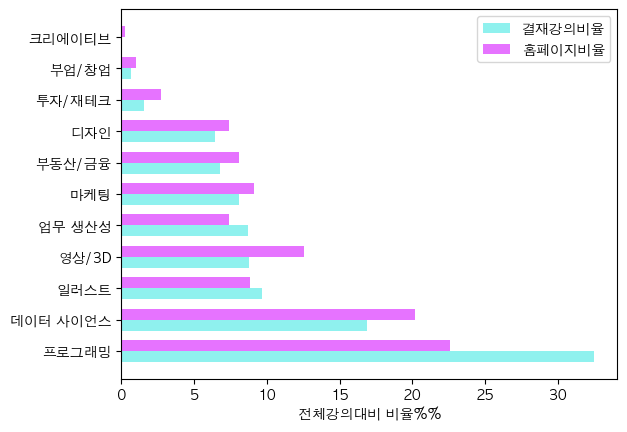

In [16]:
x_label = df_temp.index
x = np.arange(len(x_label))
y_1 = df_temp['c_count']
y_2 = df_temp['h_count']
# 넓이 지정
width = 0.35
# subplots 생성
fig, axes = plt.subplots()
# 넓이 설정
axes.barh(x - width/2, y_1, width, align='center', alpha=0.5, color=(33/255,229/255,222/255))
axes.barh(x + width/2, y_2, width, align='center', alpha=0.8, color=(224/255,80/255,255/255))
# xtick 설정
plt.yticks(x)
axes.set_yticklabels(x_label)
plt.xlabel('전체강의대비 비율%%')
plt.title('')
plt.legend(['결재강의비율', '홈페이지비율'])
plt.show()

###### 날짜/시간 데이터 변환 및 분리

In [ ]:
# Converting date_time to date and time.

rawdata = pd.read_csv(dataset+"rawdata_eng.csv")

df = rawdata['transaction_date_time'].str.split(" ", n=5, expand=True)
rawdata['Date'] = df[0].str.cat([df[1], df[2]], sep="")
rawdata['Time'] = df[3].str.cat([df[4]], sep=" ")

# Converting time to 24H format

rawdata["Time"] = rawdata["Time"].str.replace("오후", "PM").str.replace("오전","AM")
rawdata['Time'] = rawdata['Time'].apply(lambda x: datetime.datetime.strptime(x, '%p %I:%M:%S').strftime('%H:%M:%S'))
df = rawdata
# rawdata.to_csv(dataset + "rawdata.csv", index=False)

###### 불필요한 데이터 처리

In [ ]:
# Deleting Rows

# 크리에이티브
print("Number of rows before deletion:", len(df))
df = df[df["l_categories"] != "크리에이티브"]
print("Number of rows after deletion:", len(df))

# Format 컬럼

df = df.drop("l_format", axis=1)
df = df.drop("l_type", axis=1)

# rowdata_eng.to_csv(dataset + "columns_deleted.csv", index=False)

###### 숫자 데이터 컬럼 형 변환 (Obj -> Float)

In [ ]:
# Convert dtype
df = df.replace("-",np.nan)
df["sold_price"] = df["sold_price"].astype(float)
df["actual_sold_price"] = df["actual_sold_price"].astype(float)
df["coupon_discount"] = df["coupon_discount"].astype(float)
df["transaction_amount"] = df["transaction_amount"].astype(float)
df["refund_amount"] = df["refund_amount"].astype(float)
type_converted = df
# type_converted.to_csv(dataset + "space_PLEASE.csv", index=False)

###### 코스 이름 컬럼 cleansing

In [ ]:
# Removing date range in course_name

type_converted["course_name"] = type_converted["course_name"].apply(clean_course_name)
df_yes_space = type_converted
df_yes_space
df_yes_space.to_csv(dataset +"df_yes_space.csv", index = False)

###### 패키지 별 분류

In [ ]:
# Grouping courses by Packages

# "The Red" had many variances, needed to cleanse the course_name once again solely for this
df_yes_space["course_name"] = df_yes_space["course_name"].apply(lambda x: x.replace(" ", "").lower())
df_no_space = df_yes_space

# Applying def course_packages.
df_no_space["course_group"] = df_no_space.apply(course_packages, axis=1)
df_no_space["course_name"] = rawdata["course_name"]
df_no_space.to_csv(dataset +"Packages_Separated.csv", index = False)

# Generating CSV file for each Package.
grouped_df = df_no_space.groupby("course_group")

for group_name, group_df in grouped_df:
    if group_name == "Other":
#     groupname = group_name.replace("/", "_")
        filename = f"{group_name}.csv"
        group_df.to_csv(GROUPED + f"{filename}", index=False)
    else:
        pass

###### 패키지 별 분류된 CSV파일 생성

In [ ]:
# Some packages only had one course each, needed to re-classify them as others
for file in all_file_locations["grouped"]:
    df = pd.read_csv(file, low_memory=False)
    # print(file, file.split("/")[-1].split(".")[0] ,len(set(df["course_name"])))

df_new = pd.DataFrame()
for group_name, group_df in grouped_df:
    # We don't need to check Other.csv as we want to add more data to it
    if group_name == "Other":
        continue
    else:
        # Check if any Package has only one course
        if len(set(group_df["course_name"])) == 1:
            # There is only one course in [무료강의], but as it seemed more legit if we separate it from Others.
            if group_name == "[무료강의]":
                # Adding up [무료강의].csv to final CSV folder
                group_df.to_csv(FINAL_GROUP + "[무료강의].csv", index=False)
                pass
            else:
                # Add all packages that only has one course to df_new
                df_new = pd.concat([df_new, group_df])

        else:
            # Adding all the packages with multiple courses to the final CSV folder.
            filetitle = group_name.replace("/", "_")
            group_df.to_csv(FINAL_GROUP + f"{filetitle}.csv", index=False)

df_other = pd.read_csv(GROUPED + "Other.csv")
df_all = pd.concat([df_new, df_other])
df_all.to_csv(FINAL_GROUP + "Others.csv", index=False)

###### 쿠폰 분류 추가

In [ ]:
internal_coupons = {"내부" : "internal",
                    "검수" : "internal",
                    "검토" : "internal",
                    "협업" : "internal",
                    "업무" : "internal",
                    "참고" : "internal",
                    "직원" : "internal",
                    "강사" : "internal",
                    "QA" : "internal",
                    "테스트" : "internal",
                    "조교" : "internal",
                    "test" : "internal",
                    "마케팅" : "internal",
                    "신해동" : "internal"
                   }
external_coupons = {"WELCOME" : "welcome",
                    "welcome" : "welcome",
                    "Welcome" : "welcome",
                     "페이백" : "payback",
                     "1+1" : "bogo",
                     "산학" : "univ",
                     "기수강자" : "return",
                     "미리보기" : "preview",
                     "100%": "free",
                     "무료" : "free"
                    }

In [ ]:
df = pd.read_csv(dataset + 'Packages_Separated.csv') #추가할 데이터 부르기

df = coupons(df)
df.to_csv(dataset+"final_prep_file.csv")